In [4]:
pip install -r requirement.txt

  Using cached optax-0.1.3-py3-none-any.whl (145 kB)
  Using cached autograd-1.5-py3-none-any.whl (48 kB)
  Using cached jax-0.4.1.tar.gz (1.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement jaxlib==0.4.1 (from versions: none)
ERROR: No matching distribution found for jaxlib==0.4.1


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax;

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)

In [ ]:
def convolutional_layer(weights, wires, skip_first_layer=True):
    """Adds a convolutional layer to a circuit.
    Args:
        weights (np.array): 1D array with 15 weights of the parametrized gates.
        wires (list[int]): Wires where the convolutional layer acts on.
        skip_first_layer (bool): Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"

    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])

In [ ]:
def pooling_layer(weights, wires):
    """Adds a pooling layer to a circuit.
    Args:
        weights (np.array): Array with the weights of the conditional U3 gate.
        wires (list[int]): List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"

    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w)
            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])

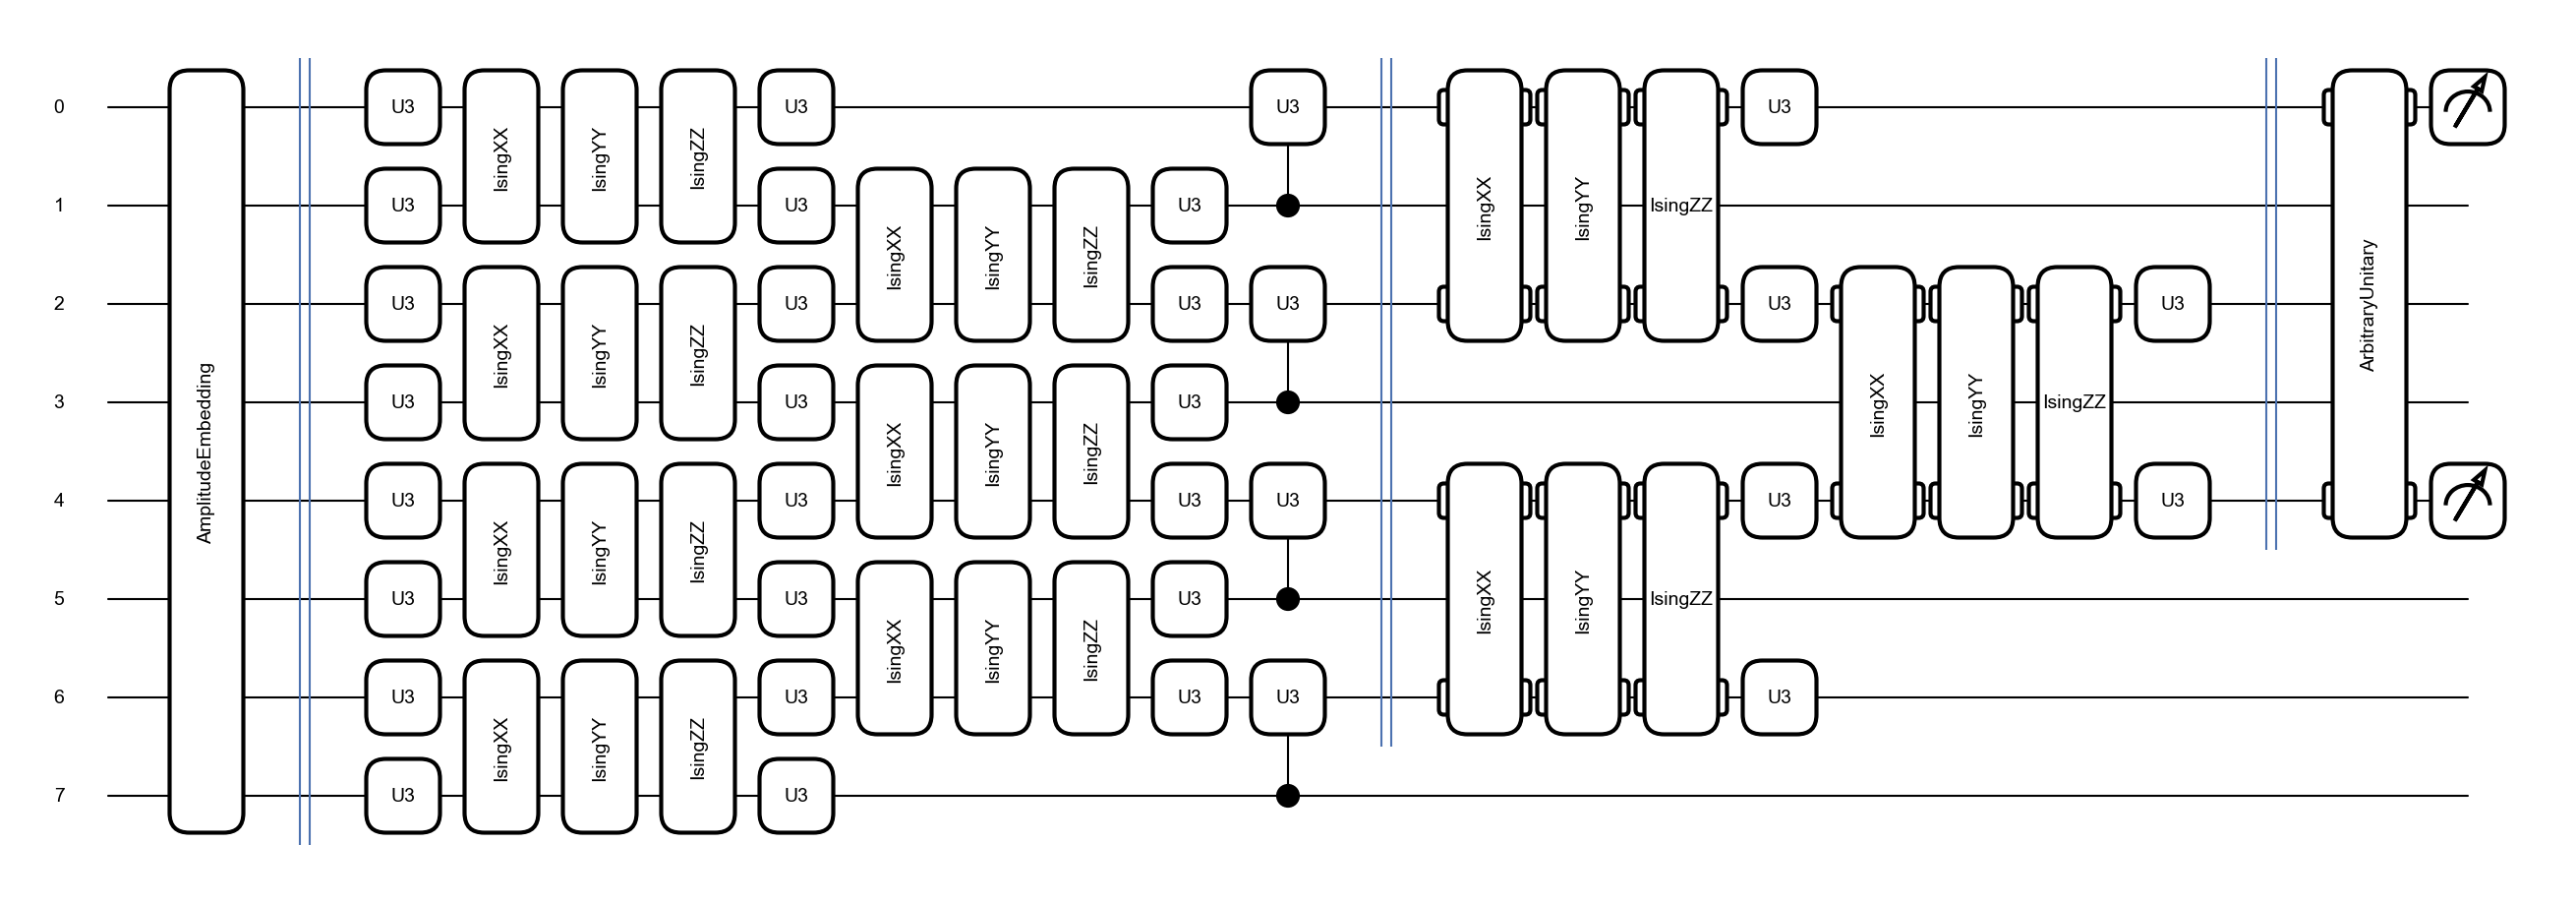

In [67]:
def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True, do_pooling=True):
    """Apply both the convolutional and pooling layer."""
    convolutional_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    if do_pooling:
        pooling_layer(kernel_weights[15:], n_wires)


def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    qml.ArbitraryUnitary(weights, wires)


num_wires = 8
device = qml.device("default.qubit", wires=num_wires)


@qml.qnode(device, interface="jax")
def conv_net(weights, last_layer_weights, features):
    """Define the QCNN circuit
    Args:
        weights (np.array): Parameters of the convolution and pool layers.
        last_layer_weights (np.array): Parameters of the last dense layer.
        features (np.array): Input data to be embedded using AmplitudEmbedding."""

    layers = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layers):
        dp = True
        if j == layers - 1:
             dp = False
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0), do_pooling=dp)
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert last_layer_weights.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights.size}"
    )
    dense_layer(last_layer_weights, wires)
    # return qml.probs(wires=(0,2, 4, 6))
    return qml.probs(wires=(0, 4))


fig, ax = qml.draw_mpl(conv_net)(
    np.random.rand(18, 2), np.random.rand(4 ** 2 - 1), np.random.rand(2 ** num_wires)
)
plt.show()

In [68]:
# load test_data and train_data
test_data = np.load("eval_data.npy", allow_pickle=True)
train_data = np.load("train_data.npy", allow_pickle=True)


In [71]:
# stack all the data
X = train_data[0][0]

for i in range(1, len(train_data)):
    X = np.vstack((X, train_data[i][0]))

y = train_data[0][1]
for i in range(1, len(train_data)):
    y = np.vstack((y, train_data[i][1]))

X_test = test_data[0][0]
Y_test = test_data[0][1]

for i in range(1, len(test_data)):
    X_test = np.vstack((X_test, test_data[i][0]))
    Y_test = np.vstack((Y_test, test_data[i][1]))


In [72]:
X.shape

(7152, 21, 4)

In [73]:
def one_hot_encode(arr):
    """
    Perform one-hot encoding on a 1D NumPy array
    """
    num_categories = np.max(arr) + 1
    one_hot_encoding = np.eye(num_categories)[arr]
    return one_hot_encoding

y = one_hot_encode(y)
Y_test = one_hot_encode(Y_test)

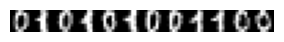

In [29]:
digits = datasets.load_digits()
images, labels = digits.data, digits.target

images = images[np.where((labels == 0) | (labels == 1))]
labels = labels[np.where((labels == 0) | (labels == 1))]

fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(3, 1))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].reshape((8, 8)), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [78]:
def load_digits_data(num_train, num_test, rng):
    """Return training and testing data of digits dataset."""
    features = train_data[0][0]
    labels = train_data[0][1]    
    labels = one_hot_encode(labels)

    features_test = test_data[0][0]
    labels_test = test_data[0][1]
    labels_test = one_hot_encode(labels_test)

    # randomly sort the data
    indices = rng.permutation(len(labels))
    features = features[indices]
    labels = labels[indices]

    # do the same for the test data
    indices = rng.permutation(len(labels_test))
    features_test = features_test[indices]

    # # only use first two classes
    # features = features[np.where((labels == 0) | (labels == 1))]
    # labels = labels[np.where((labels == 0) c (labels == 1))]

    # normalize data
    # features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))

    # subsample train and test split
    # train_indices = rng.choice(len(labels), num_train, replace=False)
    # test_indices = rng.choice(
    #     np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    # )



    # x_train, y_train = features[train_indices], labels[train_indices]
    # x_test, y_test = features[test_indices], labels[test_indices]
    x_train, y_train = features[:num_train], labels[:num_train]
    x_test, y_test = features_test[:num_test], labels_test[:num_test]

    # reshape from (n, 21, 4) to (n, 21*4)
    x_train = x_train.reshape((x_train.shape[0], -1))
    x_test = x_test.reshape((x_test.shape[0], -1))

    # reshape test from (n, 1, 4) to (n, 4)
    y_train = y_train.reshape((y_train.shape[0], -1))
    y_test = y_test.reshape((y_test.shape[0], -1))

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )

In [79]:
a,b,c,d = load_digits_data(100, 2, np.random.RandomState(0))
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)

(100, 84)
(100, 4)
(2, 84)
(2, 4)


In [83]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    #convert one hot encoding to integer
    labels = jnp.argmax(labels, axis=1)
    cost = lambda weights, weights_last, feature, label: (conv_net(weights, weights_last, feature)[label])
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


@jax.jit
def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    # out = compute_out(weights, weights_last, features, labels)
    # return jnp.sum(out)/len(out)
    labels = jnp.argmax(labels, axis=1)
    # get argmax of the output
    cost = lambda weights, weights_last, feature, label: jnp.argmax(conv_net(weights, weights_last, feature))
    outs = jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )
    #check if the output is equal to the label
    return jnp.sum(outs == labels)/len(labels)

def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(18, 2), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 2 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

In [84]:
def train_qcnn(n_train, n_test, n_epochs):
    """
    Args:
        n_train  (int): number of training examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs
        desc  (string): displayed string during optimization

    Returns:
        dict: n_train,
        steps,
        train_cost_epochs,
        train_acc_epochs,
        test_cost_epochs,
        test_acc_epochs

    """
    # load data
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(learning_rate=cosine_decay_scheduler)
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        # Training step with (adam) optimizer
        train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights, weights_last = optax.apply_updates((weights, weights_last), updates)

        train_cost_epochs.append(train_cost)

        # compute accuracy on training data
        train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
        train_acc_epochs.append(train_acc)

        # compute accuracy and cost on testing data
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_acc = jnp.sum(test_out > 0.5) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = 1.0 - jnp.sum(test_out) / len(test_out)
        test_cost_epochs.append(test_cost)

    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

In [85]:
train_qcnn(n_train=2, n_test=1, n_epochs=1)

{'n_train': [2],
 'step': array([1]),
 'train_cost': [DeviceArray(0.7978926, dtype=float64)],
 'train_acc': [DeviceArray(0.5, dtype=float64)],
 'test_cost': [DeviceArray(0.66927015, dtype=float64)],
 'test_acc': [DeviceArray(0., dtype=float64)]}

In [86]:
n_test = 50
n_epochs = 100
n_reps = 100


def run_iterations(n_train):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_qcnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )
    # print results
    print(results_df.groupby("n_train").mean())
    return results_df


# run training for multiple sizes
train_sizes = [2, 5, 10, 20, 40, 80]
results_df = run_iterations(n_train=2)
for n_train in train_sizes[1:]:
    results_df = pd.concat([results_df, run_iterations(n_train=n_train)])

         train_acc  train_cost  test_acc  test_cost  step
n_train                                                  
2            0.851    0.391357  0.171528   0.745802  50.5
         train_acc  train_cost  test_acc  test_cost  step
n_train                                                  
5          0.57368     0.52861   0.22679   0.738446  50.5
         train_acc  train_cost  test_acc  test_cost  step
n_train                                                  
10         0.47295     0.59597  0.220886   0.732937  50.5
         train_acc  train_cost  test_acc  test_cost  step
n_train                                                  
20         0.38542     0.65353  0.233688   0.733598  50.5
         train_acc  train_cost  test_acc  test_cost  step
n_train                                                  
40        0.361825    0.669682  0.246498   0.729893  50.5
         train_acc  train_cost  test_acc  test_cost  step
n_train                                                  
80        0.33

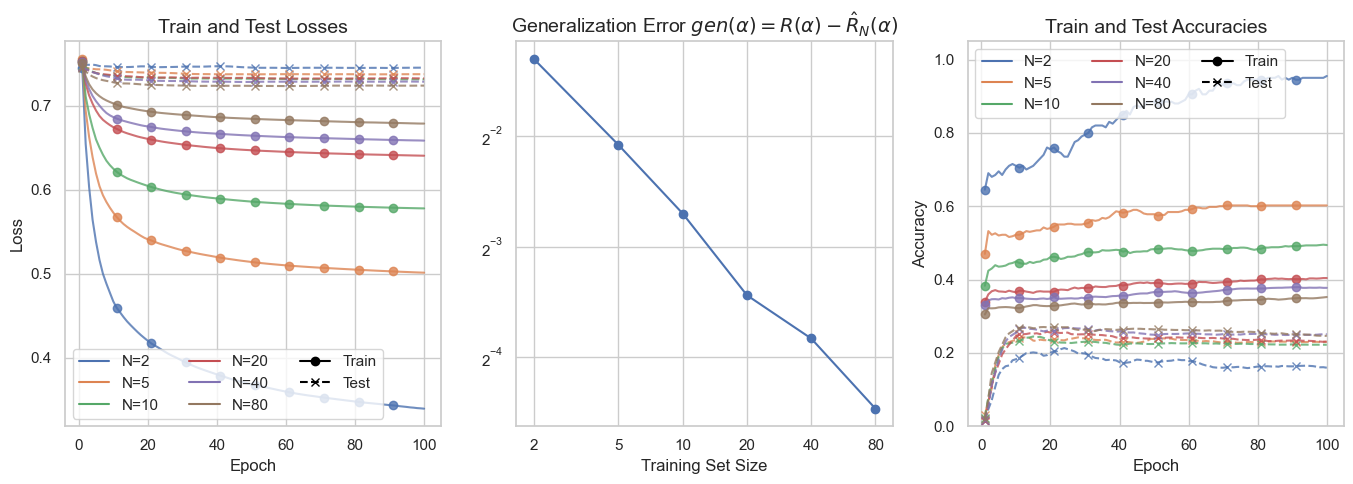

In [88]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=3, figsize=(16.5, 5))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,2,2]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    dif = df[df.step == 100].test_cost["mean"] - df[df.step == 100].train_cost["mean"]
    generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
ax = axes[1]
ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
ax.set_xscale('log')
ax.set_xticks(train_sizes)
ax.set_xticklabels(train_sizes)
ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[2]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.0, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[2].legend(handles=legend_elements, ncol=3)

axes[1].set_yscale('log', base=2)
plt.show()